## 1. Importing required libraries

In [1]:
import numpy as np
import os
import cv2
import matplotlib.pyplot as plt
from tqdm import tqdm
import tensorflow as tf
import pandas as pd
from PIL import Image
import matplotlib.patches as patches


2023-12-18 19:07:28.679975: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-12-18 19:07:28.712297: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-12-18 19:07:28.712902: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-18 19:07:29.253870: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
!python3 -c "import tensorflow as tf; print(tf.config.list_physical_devices('GPU'))"

2023-12-18 19:07:30.474044: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-18 19:07:30.474095: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-18 19:07:30.475165: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-18 19:07:30.480755: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-18 19:07:31.066644: W tensorflow/compiler/tf2

## 2. Loading the dataset

In [3]:
train_images_folder = "./dataset/train/images"
test_images_folder = "./dataset/test/images"

train_annotations_folder = "./dataset/train/annotations"
test_annotations_folder = "./dataset/test/annotations"

In [4]:
m_train = len(os.listdir(train_images_folder))
m_test = len(os.listdir(test_images_folder))

max_train_images_per_class = 2400
max_test_images_per_class = 400

num_classes = 10

# reading an image to figure out the dimensions 
img = cv2.imread(f"./dataset/train/images/0.png", cv2.IMREAD_GRAYSCALE)

h,w = img.shape

# Preallocate memory for the images and labels
train_images = np.empty((max_train_images_per_class * 10, h, w), dtype=np.float32)
train_labels = np.empty((max_train_images_per_class * 10, num_classes+4 ), dtype=np.float32)
test_images = np.empty((max_test_images_per_class * 10, h, w), dtype=np.float32)
test_labels = np.empty((max_test_images_per_class * 10, num_classes+4), dtype=np.float32)

print(f"Train data size: {max_train_images_per_class * 10}  |  Test data size: {max_test_images_per_class * 10}")

class_counts = {}

train_count = 0
# loading the train data (taking only 3000 images per class)
for i in range(m_train):
    
    if train_count == max_train_images_per_class * 10:
        print(f'Loaded {max_train_images_per_class} train images per class')
        break
    
    # reading the annotation to get labels
    with open(f"./dataset/train/annotations/{i}.txt") as f:
        labels_str = f.read().strip('\n')
        label , x_min , y_min , x_max , y_max = map(int, labels_str.split(' '))

    
    # checking if the counts of the current label are less than max_images_per_class
    if class_counts.get(label,0) < max_train_images_per_class:

        # reading the image
        img = cv2.imread(f"./dataset/train/images/{i}.png", cv2.IMREAD_GRAYSCALE)

        # normalize the image and store it
        train_images[train_count] = img / 255

        # One-hot encode the label
        one_hot_label = np.eye(num_classes)[label]
        
        # bounding box coordinates
        bbox_coordinates = np.array([x_min/w , y_min/h , x_max/w , y_max/h])

        # Concatenate one_hot_label and bbox_coordinates and store it
        train_labels[train_count] = np.concatenate((bbox_coordinates, one_hot_label))
        
        # updating the count
        class_counts[label] = class_counts.get(label,0) + 1
        train_count += 1


class_counts = {}

test_count = 0
# loading the test data (taking only 500 images per class)
for i in range(m_test):

    if test_count == max_test_images_per_class * 10:
        print(f'Loaded {max_test_images_per_class} test images per class')
        break
        
    # reading the annotation to get labels
    with open(f"./dataset/test/annotations/{i}.txt") as f:
        labels_str = f.read().strip('\n')
        label , x_min , y_min , x_max , y_max = map(int, labels_str.split(' '))
        
    # checking if the counts of the current label are less than max_images_per_class
    if class_counts.get(label,0) < max_test_images_per_class:
        
        # reading the image
        img = cv2.imread(f"./dataset/test/images/{i}.png", cv2.IMREAD_GRAYSCALE)

        # normalize the image
        test_images[test_count] = img / 255

        # One-hot encode the label
        one_hot_label = np.eye(num_classes)[label]
        
        # bounding box coordinates
        bbox_coordinates = np.array([x_min/w , y_min/h , x_max/w , y_max/h])

        # Concatenate one_hot_label and bbox_coordinates and store it
        test_labels[test_count] = np.concatenate((bbox_coordinates, one_hot_label))
        
        # updating the count
        class_counts[label] = class_counts.get(label,0) + 1
        test_count += 1



Train data size: 24000  |  Test data size: 4000
Loaded 2400 train images per class
Loaded 400 test images per class


In [5]:
# renaming our arrays
X_train = train_images
Y_train = train_labels
X_test = test_images
Y_test = test_labels

print(f" X_train shape: {X_train.shape} \n Y_train shape: {Y_train.shape} \n X_test shape: {X_test.shape} \n Y_test shape: {Y_test.shape}")

 X_train shape: (24000, 80, 80) 
 Y_train shape: (24000, 14) 
 X_test shape: (4000, 80, 80) 
 Y_test shape: (4000, 14)


In [6]:
# Reshape X_train to (24000, 80, 80, 1)
X_train = np.reshape(X_train, (X_train.shape[0], 80, 80, 1))
X_test = np.reshape(X_test, (X_test.shape[0], 80, 80, 1))

print(f" X_train shape: {X_train.shape} \n Y_train shape: {Y_train.shape} \n X_test shape: {X_test.shape} \n Y_test shape: {Y_test.shape}")

 X_train shape: (24000, 80, 80, 1) 
 Y_train shape: (24000, 14) 
 X_test shape: (4000, 80, 80, 1) 
 Y_test shape: (4000, 14)


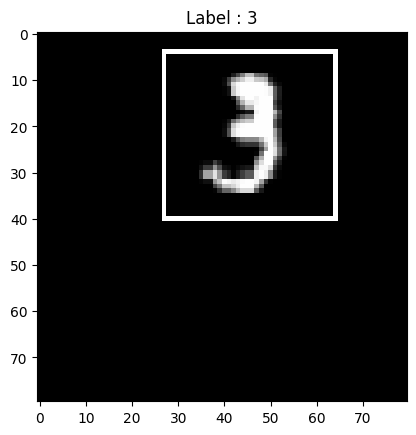

In [7]:
ind = 10

img = (X_train[ind,:]*255)

xmin,ymin,xmax,ymax = Y_train[ind,:4]
label = np.argmax(Y_train[ind,4:])

xmin = int(xmin * w)
xmax = int(xmax * w)
ymin = int(ymin * h)
ymax = int(ymax * h)


bbox = cv2.rectangle(img, (xmin,ymin), (xmax, ymax), (255,0,0) , 1)    # (pic , start , end , color, thickness)

plt.imshow(bbox , cmap='gray')
plt.title(f"Label : {label}")
plt.show()

## Convolutional Model

In [8]:
def convolutional_model(input_shape):

    input_img = tf.keras.Input(shape=input_shape)
    C1 = tf.keras.layers.Conv2D(16,3,padding='same',activation='relu')(input_img)
    P1 = tf.keras.layers.MaxPool2D(pool_size=(8,8),strides=8,padding='same')(C1)
    
    C2 = tf.keras.layers.Conv2D(32,3,padding='same',activation='relu')(P1)
    P2 = tf.keras.layers.MaxPool2D(pool_size=(4,4),strides=4,padding='same')(C2)

    C3 = tf.keras.layers.Conv2D(64,3,padding='same',activation='relu')(P2)
    P3 = tf.keras.layers.MaxPool2D(pool_size=(2,2),strides=2,padding='same')(C3)
    
    F = tf.keras.layers.Flatten()(P3)
    
    output_1 = tf.keras.layers.Dense(4,activation='linear',name='bbox_output')(F)
    output_2 = tf.keras.layers.Dense(10,activation='softmax',name='class_output')(F)
    
    model = tf.keras.Model(inputs=input_img, outputs=[output_1,output_2])
    return model

In [9]:
conv_model = convolutional_model((80, 80,1))
conv_model.compile(optimizer='adam',
                  loss={'bbox_output':'mean_squared_error','class_output':'categorical_crossentropy'},
                  metrics=['accuracy'])
conv_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 80, 80, 1)]          0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 80, 80, 16)           160       ['input_1[0][0]']             
                                                                                                  
 max_pooling2d (MaxPooling2  (None, 10, 10, 16)           0         ['conv2d[0][0]']              
 D)                                                                                               
                                                                                                  
 conv2d_1 (Conv2D)           (None, 10, 10, 32)           4640      ['max_pooling2d[0][0]']   

2023-12-18 19:08:26.501299: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-12-18 19:08:26.502043: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1960] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [10]:
Y_train_bbox = Y_train[:, :4]
Y_train_class = Y_train[:, 4:]

Y_test_bbox = Y_test[:, :4]
Y_test_class = Y_test[:, 4:]

train_dataset = tf.data.Dataset.from_tensor_slices((X_train, {"bbox_output": Y_train_bbox, "class_output": Y_train_class})).batch(64)
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, {"bbox_output": Y_test_bbox, "class_output": Y_test_class})).batch(64)


2023-12-18 19:08:27.982542: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 614400000 exceeds 10% of free system memory.
2023-12-18 19:08:28.354515: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 102400000 exceeds 10% of free system memory.


In [11]:
history = conv_model.fit(train_dataset, epochs=100, validation_data=test_dataset)

2023-12-18 19:08:34.751342: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 614400000 exceeds 10% of free system memory.


Epoch 1/100
  5/375 [..............................] - ETA: 11s - loss: 2.5295 - bbox_output_loss: 0.2244 - class_output_loss: 2.3052 - bbox_output_accuracy: 0.4281 - class_output_accuracy: 0.0844

2023-12-18 19:08:35.752818: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 26214400 exceeds 10% of free system memory.
2023-12-18 19:08:35.772628: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 20448000 exceeds 10% of free system memory.


375/375 [==============================] - 13s 32ms/step - loss: 1.6743 - bbox_output_loss: 0.0137 - class_output_loss: 1.6606 - bbox_output_accuracy: 0.8789 - class_output_accuracy: 0.4038 - val_loss: 3.2835 - val_bbox_output_loss: 0.0165 - val_class_output_loss: 3.2670 - val_bbox_output_accuracy: 0.7955 - val_class_output_accuracy: 0.1698
Epoch 2/100
375/375 [==============================] - 12s 32ms/step - loss: 0.9503 - bbox_output_loss: 0.0093 - class_output_loss: 0.9410 - bbox_output_accuracy: 0.8696 - class_output_accuracy: 0.6889 - val_loss: 2.0657 - val_bbox_output_loss: 0.0112 - val_class_output_loss: 2.0545 - val_bbox_output_accuracy: 0.8540 - val_class_output_accuracy: 0.3557
Epoch 3/100
375/375 [==============================] - 12s 33ms/step - loss: 0.6989 - bbox_output_loss: 0.0078 - class_output_loss: 0.6911 - bbox_output_accuracy: 0.8768 - class_output_accuracy: 0.7721 - val_loss: 1.5604 - val_bbox_output_loss: 0.0092 - val_class_output_loss: 1.5512 - val_bbox_output_

In [12]:
def plot_metrics(history):
    # The history.history["loss"] entry is a dictionary with as many values as epochs that the
    # model was trained on. 
    df_loss_acc = pd.DataFrame(history.history)
    df_loss= df_loss_acc[['bbox_output_loss','val_bbox_output_loss']]
    df_loss.rename(columns={'bbox_output_loss':'train bbox loss','val_bbox_output_loss':'validation bbox loss'},inplace=True)
    df_acc= df_loss_acc[['bbox_output_accuracy','val_bbox_output_accuracy']]
    df_acc.rename(columns={'bbox_output_accuracy':'train bbox accuracy','val_bbox_output_accuracy':'validation box accuracy'},inplace=True)
    
    df_loss_class= df_loss_acc[['class_output_loss','val_class_output_loss']]
    df_loss_class.rename(columns={'class_output_loss':'train classfication loss','val_class_output_loss':'validation classification loss'},inplace=True)
    df_acc_class= df_loss_acc[['class_output_accuracy','val_class_output_accuracy']]
    df_acc_class.rename(columns={'class_output_accuracy':'train classification accuracy','val_class_output_accuracy':'validation classification accuracy'},inplace=True)
    
    
    # Create a figure and a set of subplots
    fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(20,16))
    
    # Plot loss on the first subplot
    df_loss.plot(title='Model loss Localization', ax=axs[0][0])
    axs[0][0].set(xlabel='Epoch', ylabel='Loss')
    
    # Plot accuracy on the second subplot
    df_acc.plot(title='Model Accuracy Localization', ax=axs[0][1])
    axs[0][1].set(xlabel='Epoch', ylabel='Accuracy')
    
    # Plot classification loss on the third subplot
    df_loss_class.plot(title='Model loss Classification', ax=axs[1][0])
    axs[1][0].set(xlabel='Epoch', ylabel='Loss')
    
    # Plot classification accuracy on the third subplot
    df_acc_class.plot(title='Model Accuracy Classification', ax=axs[1][1])
    axs[1][1].set(xlabel='Epoch', ylabel='Accuracy')
    
    # Display the figure with the subplots
    plt.show()

In [13]:
def predict_and_plot(ind, model):

    # Assuming X_test[ind,:] is your numpy array
    original = X_test[ind,:]*255
    
    # Create a copy of the array
    img = np.copy(original)

    # Reshape the array to 2D if it's grayscale
    if img.shape[-1] == 1:
        img = img.reshape(img.shape[0], img.shape[1])

    # Convert the numpy array to an image
    image = Image.fromarray(img.astype('uint8'))
    # Convert the image into RGB
    rgb_image = image.convert('RGB')

    # Convert the PIL Image back to a numpy array for OpenCV
    rgb_image_cv2 = np.array(rgb_image)

    xmin,ymin,xmax,ymax = Y_test[ind,:4]
    g_truth = np.argmax(Y_test[ind,4:])
    
    xmin = int(xmin * w)
    xmax = int(xmax * w)
    ymin = int(ymin * h)
    ymax = int(ymax * h)
    
    
    cv2.rectangle(rgb_image_cv2, (xmin,ymin), (xmax, ymax), (255,0,0) , 1)    # (pic , start , end , color, thickness)
    
    pred_image= np.copy(X_test[ind])
    # Extract the example and add an extra dimension at the start
    pred_image = np.expand_dims(pred_image, axis=0)

    bbox, classs = model.predict(pred_image)

    
    
    xmin,ymin,xmax,ymax = bbox[0]
    label = np.argmax(classs)
    
    xmin = int(xmin * w)
    xmax = int(xmax * w)
    ymin = int(ymin * h)
    ymax = int(ymax * h)

    print(xmin,ymin,xmax,ymax)
    
    cv2.rectangle(rgb_image_cv2, (xmin,ymin), (xmax, ymax), (0,255,0) , 1)    # (pic , start , end , color, thickness)

    # Create a red patch for ground truth
    red_patch = patches.Patch(color='red', label='Ground Truth')
    # Create a green patch for prediction
    green_patch = patches.Patch(color='green', label='Prediction')
    
    plt.imshow(rgb_image_cv2)
    plt.title(f"Ground Truth : {g_truth} Predicted Label : {label}")
    plt.legend(handles=[red_patch, green_patch])
    plt.show()
    

/tmp/ipykernel_77852/3760673571.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_loss.rename(columns={'bbox_output_loss':'train bbox loss','val_bbox_output_loss':'validation bbox loss'},inplace=True)
/tmp/ipykernel_77852/3760673571.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_acc.rename(columns={'bbox_output_accuracy':'train bbox accuracy','val_bbox_output_accuracy':'validation box accuracy'},inplace=True)
/tmp/ipykernel_77852/3760673571.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/panda

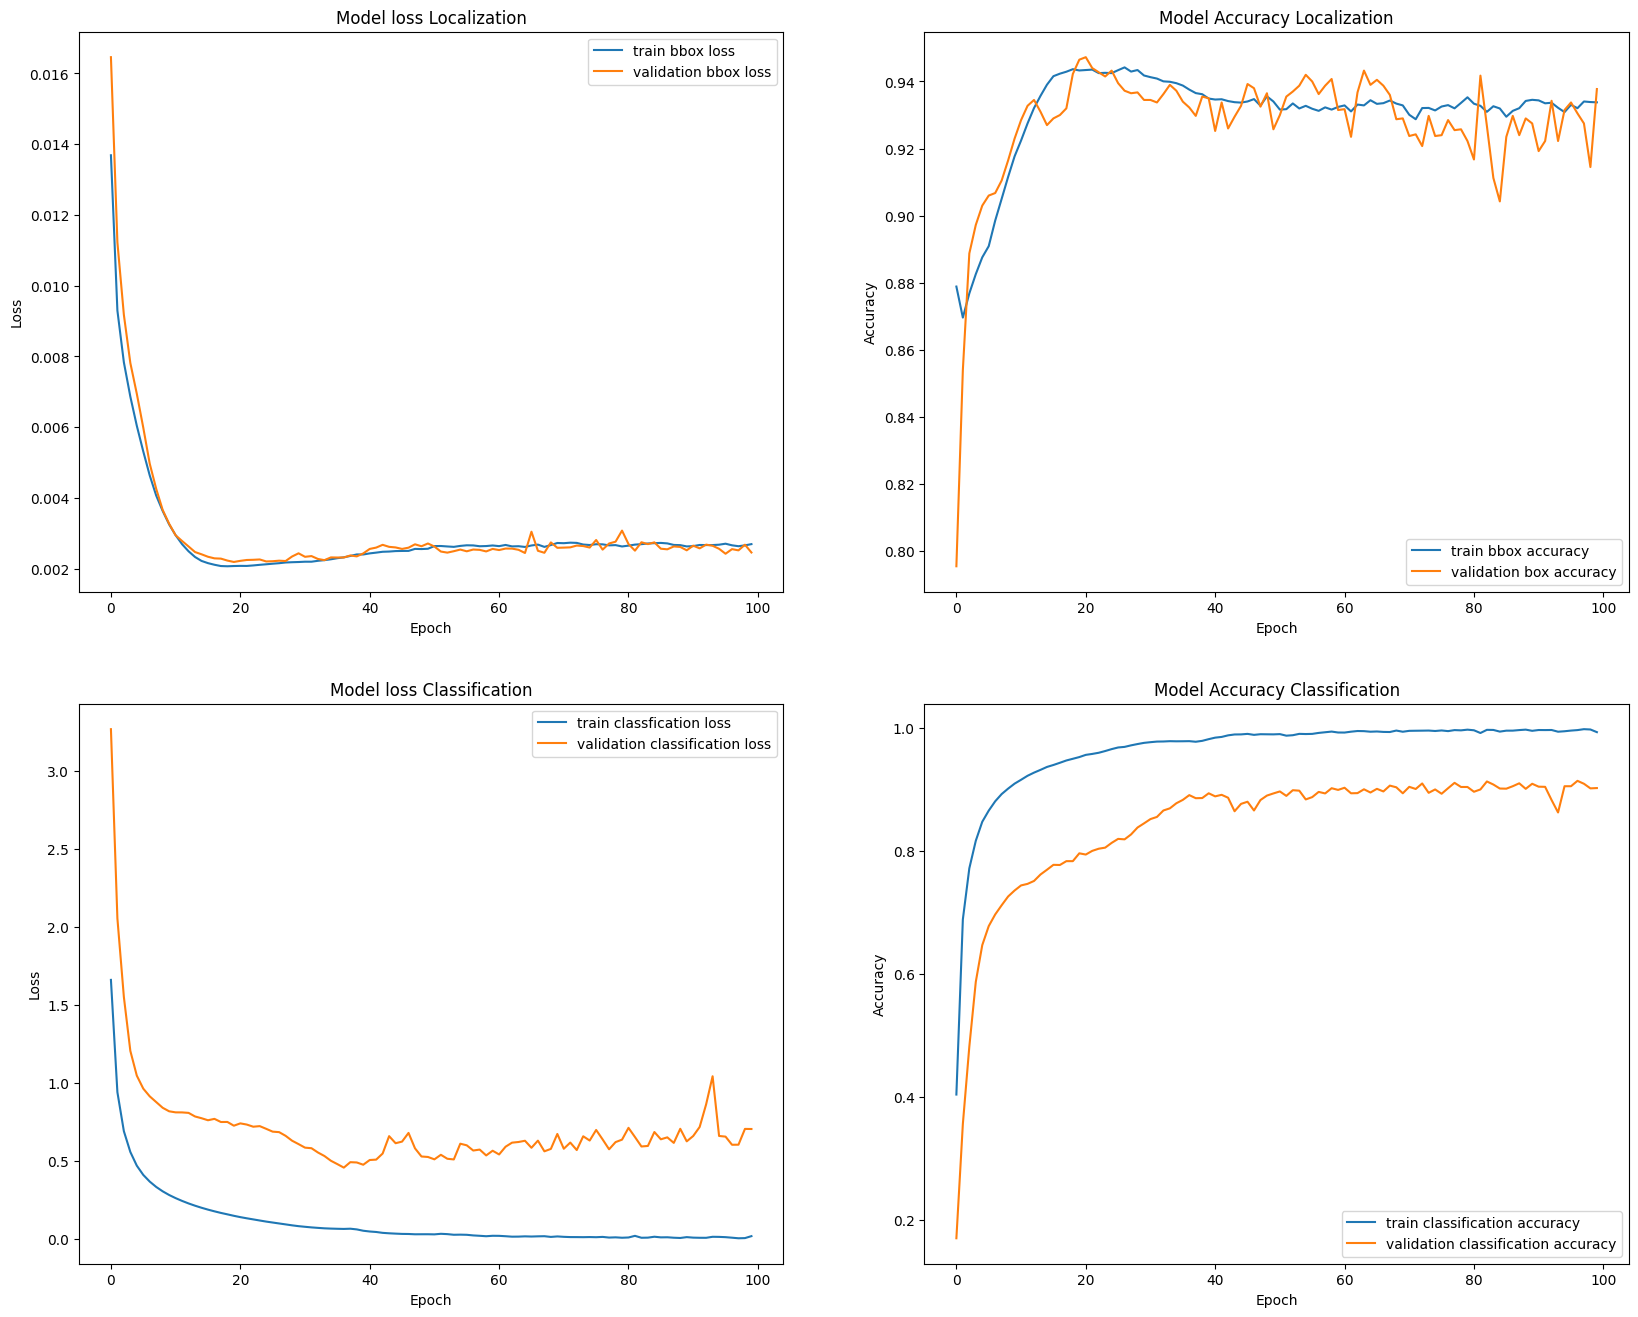

In [14]:
plot_metrics(history)

1/1 [==============================] - 0s 64ms/step
25 35 57 67


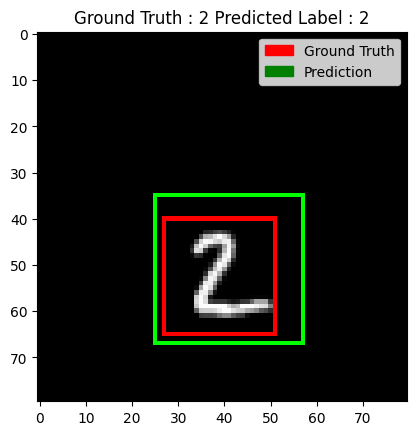

1/1 [==============================] - 0s 13ms/step
40 44 60 64


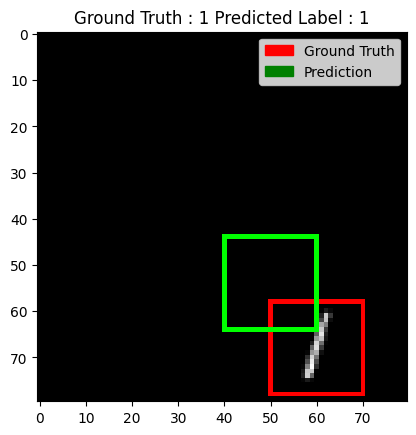

1/1 [==============================] - 0s 12ms/step
22 5 47 31


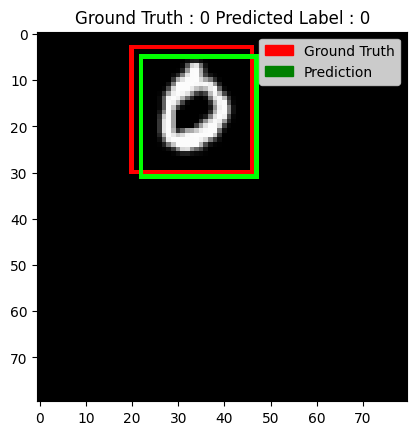

1/1 [==============================] - 0s 12ms/step
38 2 67 30


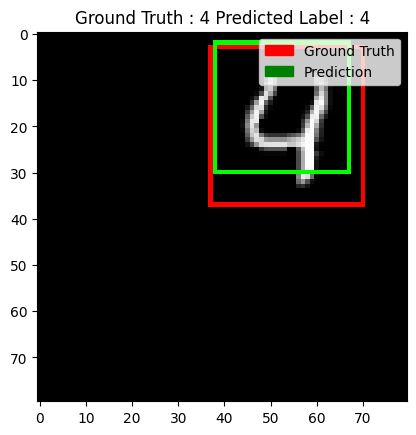

1/1 [==============================] - 0s 12ms/step
15 36 52 75


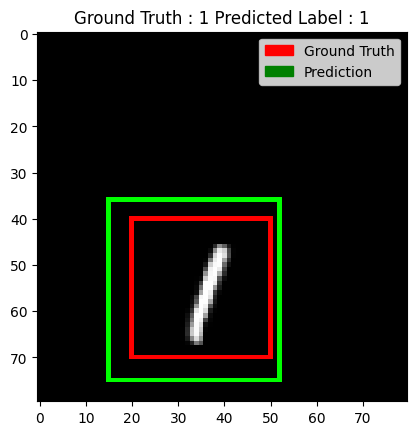

1/1 [==============================] - 0s 12ms/step
12 41 46 74


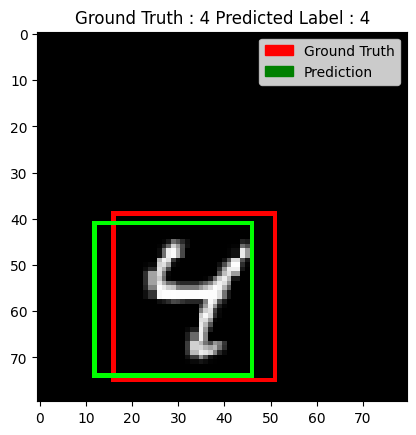

1/1 [==============================] - 0s 12ms/step
47 24 71 49


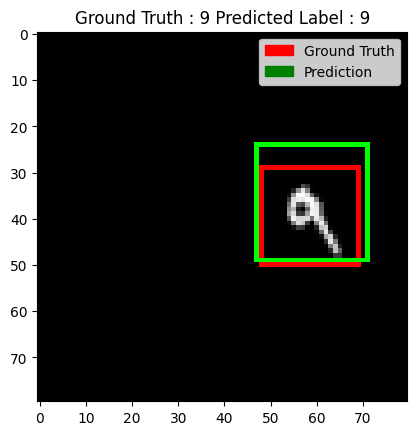

1/1 [==============================] - 0s 12ms/step
43 20 69 46


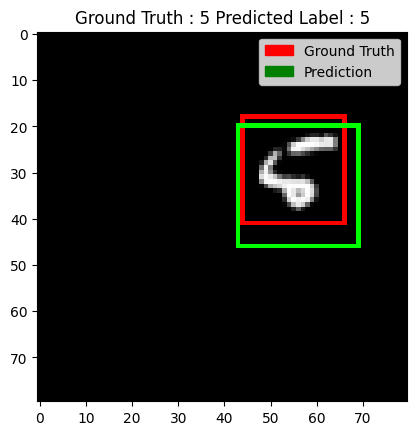

1/1 [==============================] - 0s 12ms/step
4 1 41 39


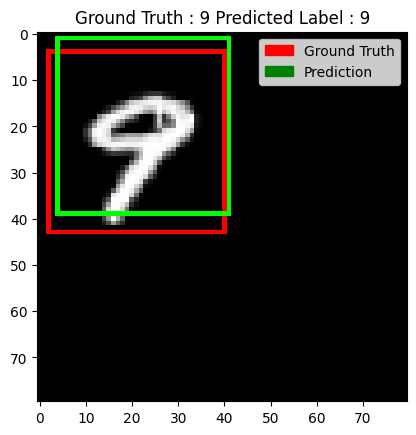

1/1 [==============================] - 0s 13ms/step
34 19 57 43


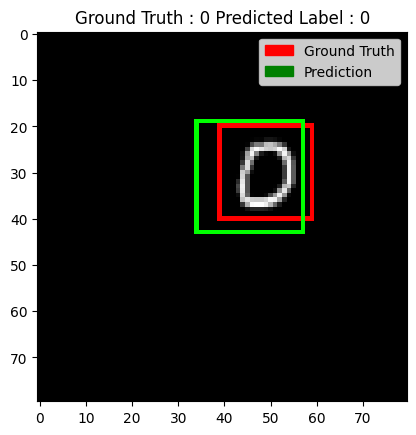

In [15]:
for i in range(10):
    predict_and_plot(1+i,conv_model)

## Defining another Model

In [16]:
def convolutional_model2(input_shape):

    input_img = tf.keras.Input(shape=input_shape)
    C1 = tf.keras.layers.Conv2D(16,3,padding='same',activation='relu')(input_img)
    P1 = tf.keras.layers.MaxPool2D(pool_size=(8,8),strides=8,padding='same')(C1)
    
    C2 = tf.keras.layers.Conv2D(32,3,padding='same',activation='relu')(P1)
    P2 = tf.keras.layers.MaxPool2D(pool_size=(4,4),strides=4,padding='same')(C2)

    C3 = tf.keras.layers.Conv2D(64,3,padding='same',activation='relu')(P2)
    P3 = tf.keras.layers.MaxPool2D(pool_size=(2,2),strides=2,padding='same')(C3)
    
    F = tf.keras.layers.Flatten()(P3)

    localization_branch = tf.keras.layers.Dense(64,activation='relu')(F)
    classification_branch = tf.keras.layers.Dense(64,activation='relu')(F)
    
    output_1 = tf.keras.layers.Dense(4,activation='linear',name='bbox_output')(localization_branch)
    output_2 = tf.keras.layers.Dense(10,activation='softmax',name='class_output')(classification_branch)
    
    model = tf.keras.Model(inputs=input_img, outputs=[output_1,output_2])
    return model

In [17]:
conv_model2 = convolutional_model2((80, 80,1))
conv_model2.compile(optimizer='adam',
                  loss={'bbox_output':'mean_squared_error','class_output':'categorical_crossentropy'},
                  metrics=['accuracy'])
conv_model2.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 80, 80, 1)]          0         []                            
                                                                                                  
 conv2d_3 (Conv2D)           (None, 80, 80, 16)           160       ['input_2[0][0]']             
                                                                                                  
 max_pooling2d_3 (MaxPoolin  (None, 10, 10, 16)           0         ['conv2d_3[0][0]']            
 g2D)                                                                                             
                                                                                                  
 conv2d_4 (Conv2D)           (None, 10, 10, 32)           4640      ['max_pooling2d_3[0][0]'

In [18]:
history2 = conv_model2.fit(train_dataset, epochs=100, validation_data=test_dataset)

Epoch 1/100
375/375 [==============================] - 13s 33ms/step - loss: 1.6333 - bbox_output_loss: 0.0110 - class_output_loss: 1.6224 - bbox_output_accuracy: 0.9134 - class_output_accuracy: 0.3940 - val_loss: 2.3517 - val_bbox_output_loss: 0.0045 - val_class_output_loss: 2.3472 - val_bbox_output_accuracy: 0.9355 - val_class_output_accuracy: 0.2575
Epoch 2/100
375/375 [==============================] - 12s 32ms/step - loss: 0.9556 - bbox_output_loss: 0.0039 - class_output_loss: 0.9518 - bbox_output_accuracy: 0.9325 - class_output_accuracy: 0.6644 - val_loss: 1.6144 - val_bbox_output_loss: 0.0038 - val_class_output_loss: 1.6106 - val_bbox_output_accuracy: 0.9388 - val_class_output_accuracy: 0.4410
Epoch 3/100
375/375 [==============================] - 12s 32ms/step - loss: 0.6854 - bbox_output_loss: 0.0033 - class_output_loss: 0.6821 - bbox_output_accuracy: 0.9381 - class_output_accuracy: 0.7665 - val_loss: 1.2957 - val_bbox_output_loss: 0.0031 - val_class_output_loss: 1.2926 - val_

/tmp/ipykernel_77852/3760673571.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_loss.rename(columns={'bbox_output_loss':'train bbox loss','val_bbox_output_loss':'validation bbox loss'},inplace=True)
/tmp/ipykernel_77852/3760673571.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_acc.rename(columns={'bbox_output_accuracy':'train bbox accuracy','val_bbox_output_accuracy':'validation box accuracy'},inplace=True)
/tmp/ipykernel_77852/3760673571.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/panda

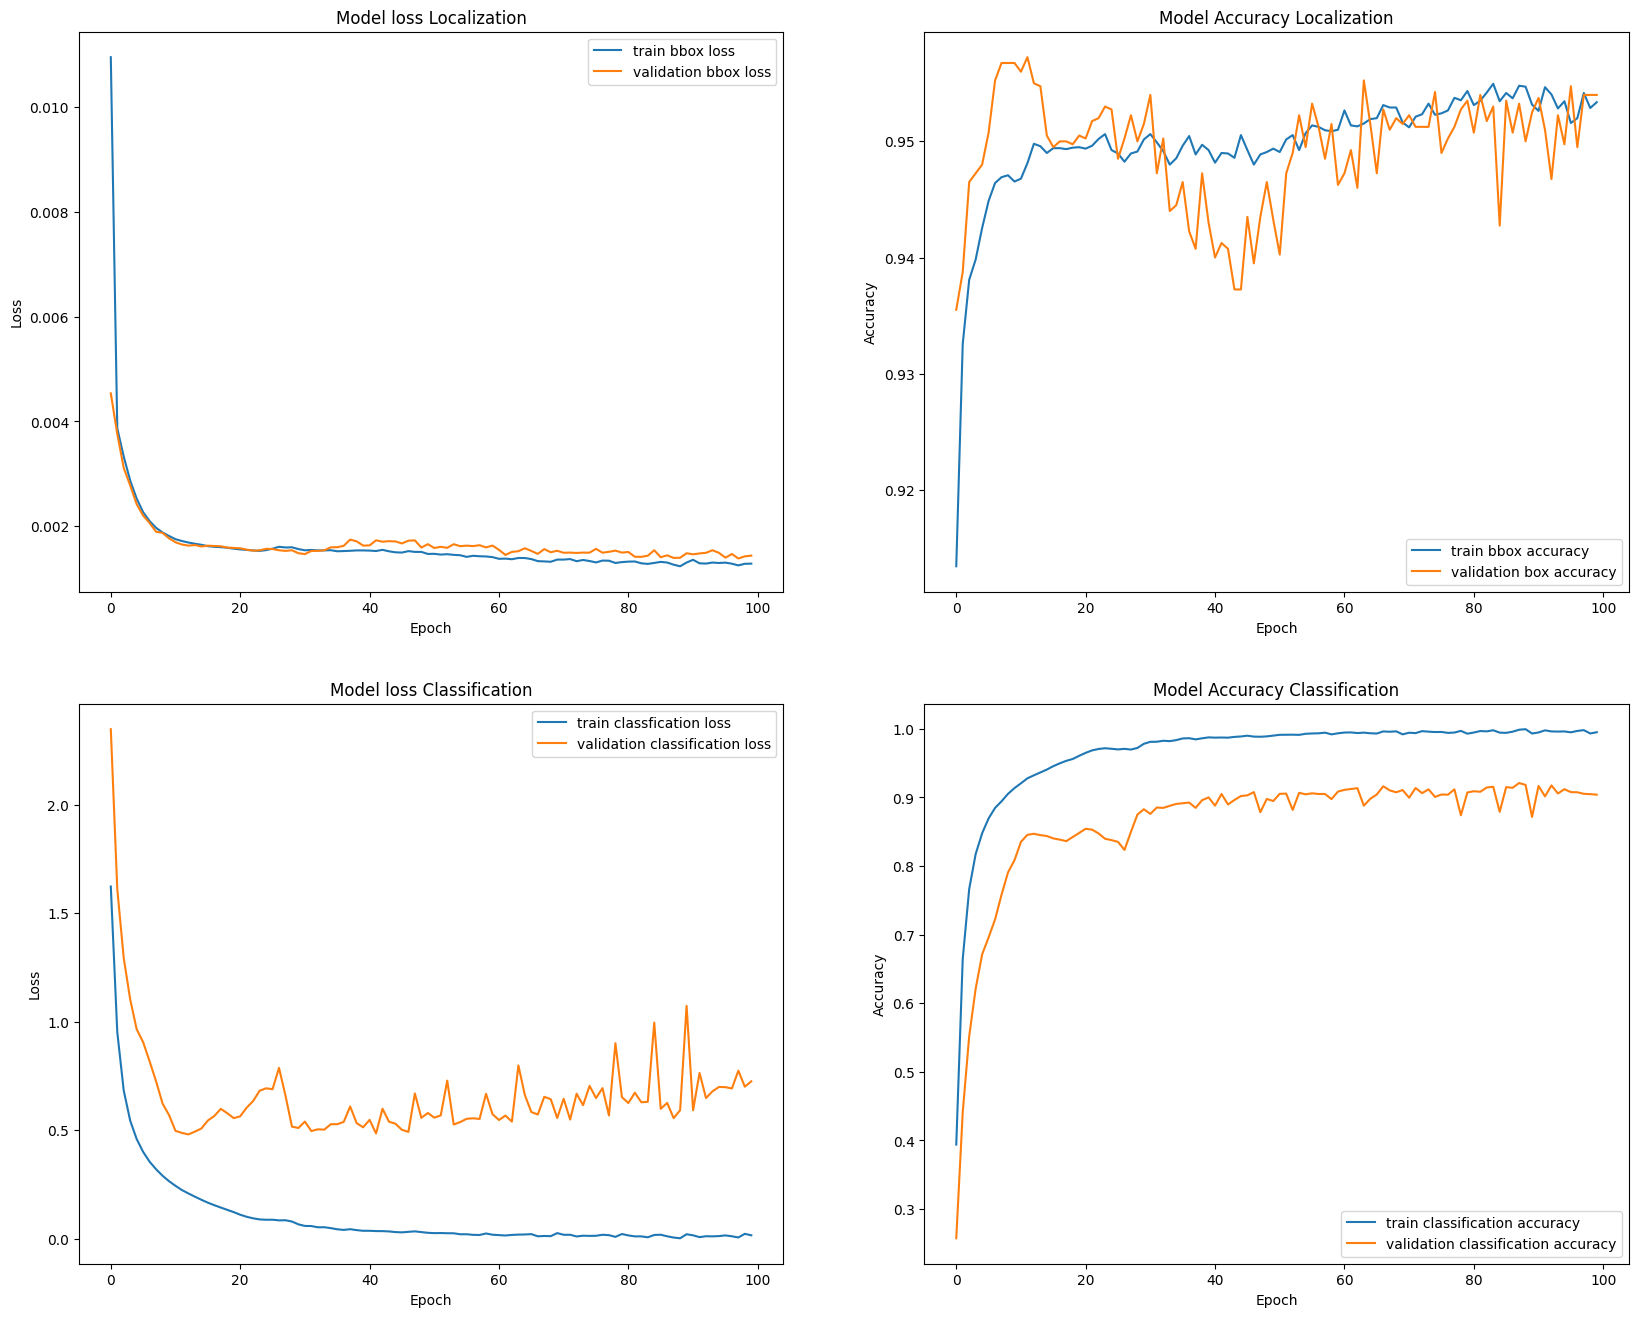

In [19]:
plot_metrics(history2)

1/1 [==============================] - 0s 54ms/step
23 40 53 70


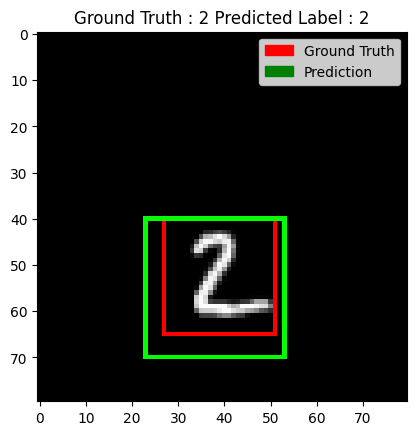

1/1 [==============================] - 0s 12ms/step
50 53 72 75


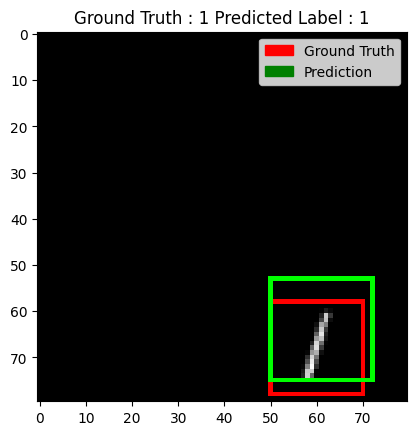

1/1 [==============================] - 0s 12ms/step
20 2 45 26


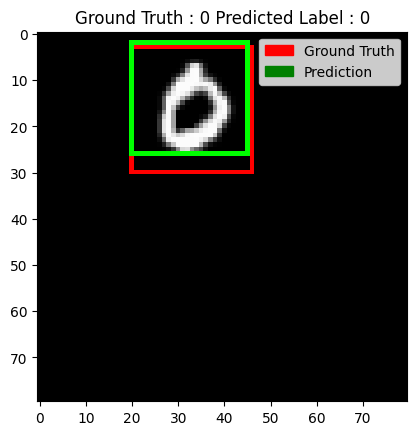

1/1 [==============================] - 0s 11ms/step
41 4 70 34


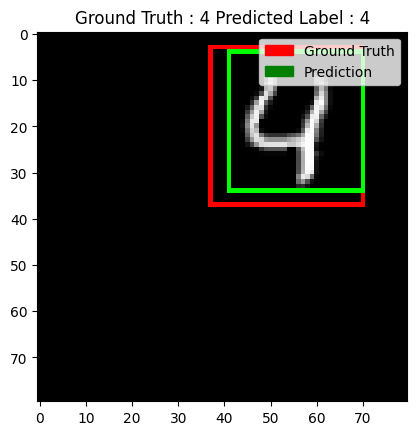

1/1 [==============================] - 0s 12ms/step
27 41 54 68


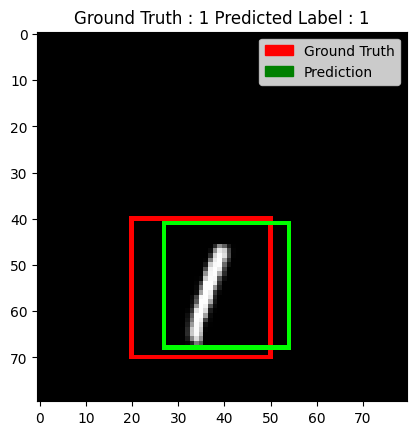

1/1 [==============================] - 0s 12ms/step
12 40 40 68


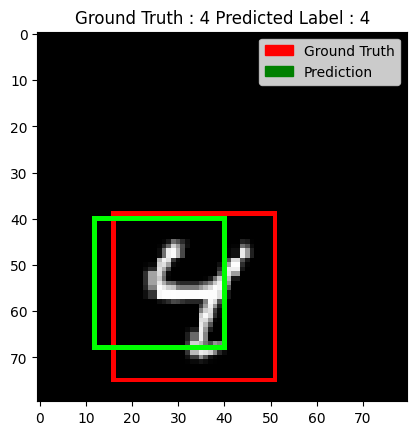

1/1 [==============================] - 0s 11ms/step
44 25 69 50


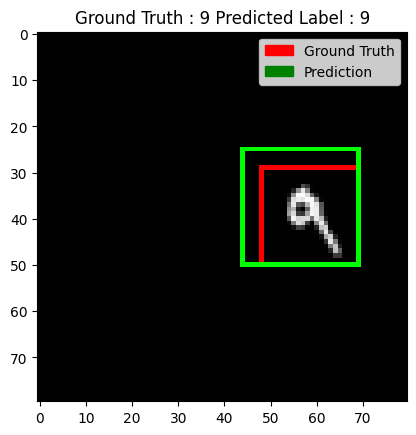

1/1 [==============================] - 0s 12ms/step
41 15 71 46


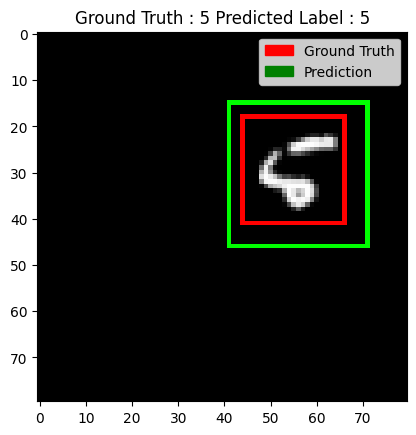

1/1 [==============================] - 0s 12ms/step
4 4 39 39


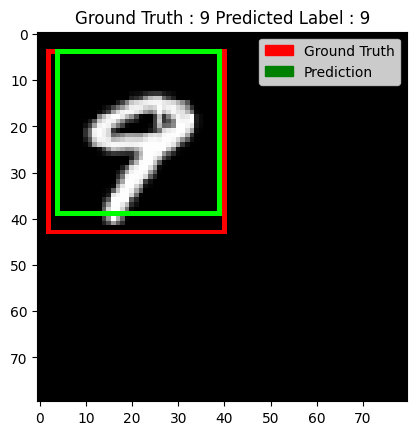

1/1 [==============================] - 0s 12ms/step
35 22 59 46


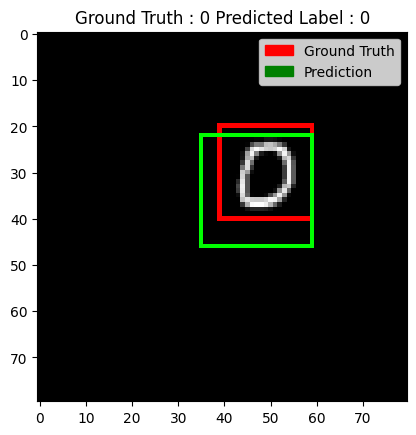

In [20]:
for i in range(10):
    predict_and_plot(1+i,conv_model2)

## Another Model

In [21]:
def convolutional_model3(input_shape):

    input_img = tf.keras.Input(shape=input_shape)
    C1 = tf.keras.layers.Conv2D(16,3,padding='same',activation='relu')(input_img)
    P1 = tf.keras.layers.MaxPool2D(pool_size=(6,6),strides=6,padding='same')(C1)
    
    C2 = tf.keras.layers.Conv2D(32,3,padding='same',activation='relu')(P1)
    P2 = tf.keras.layers.MaxPool2D(pool_size=(4,4),strides=4,padding='same')(C2)

    C3 = tf.keras.layers.Conv2D(64,3,padding='same',activation='relu')(P2)
    P3 = tf.keras.layers.MaxPool2D(pool_size=(2,2),strides=2,padding='same')(C3)

    C4 = tf.keras.layers.Conv2D(128,3,padding='same',activation='relu')(P3)
    P4 = tf.keras.layers.MaxPool2D(pool_size=(2,2),strides=2,padding='same')(C4)
    
    F = tf.keras.layers.Flatten()(P4)

    l_b1 = tf.keras.layers.Dense(32,activation='relu')(F)
    c_b1 = tf.keras.layers.Dense(32,activation='relu')(F)

    l_b2 = tf.keras.layers.Dense(16,activation='relu')(l_b1)
    c_b2 = tf.keras.layers.Dense(16,activation='relu')(c_b1)
    
    output_1 = tf.keras.layers.Dense(4,activation='linear',name='bbox_output')(l_b2)
    output_2 = tf.keras.layers.Dense(10,activation='softmax',name='class_output')(c_b2)
    
    model = tf.keras.Model(inputs=input_img, outputs=[output_1,output_2])
    return model

In [22]:
conv_model3 = convolutional_model3((80, 80,1))
conv_model3.compile(optimizer='adam',
                  loss={'bbox_output':'mean_squared_error','class_output':'categorical_crossentropy'},
                  metrics=['accuracy'])
conv_model3.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 80, 80, 1)]          0         []                            
                                                                                                  
 conv2d_6 (Conv2D)           (None, 80, 80, 16)           160       ['input_3[0][0]']             
                                                                                                  
 max_pooling2d_6 (MaxPoolin  (None, 14, 14, 16)           0         ['conv2d_6[0][0]']            
 g2D)                                                                                             
                                                                                                  
 conv2d_7 (Conv2D)           (None, 14, 14, 32)           4640      ['max_pooling2d_6[0][0]'

In [23]:
history3 = conv_model3.fit(train_dataset, epochs=100, validation_data=test_dataset)

Epoch 1/100
375/375 [==============================] - 15s 36ms/step - loss: 1.9151 - bbox_output_loss: 0.0133 - class_output_loss: 1.9017 - bbox_output_accuracy: 0.9070 - class_output_accuracy: 0.2970 - val_loss: 2.7748 - val_bbox_output_loss: 0.0052 - val_class_output_loss: 2.7695 - val_bbox_output_accuracy: 0.9302 - val_class_output_accuracy: 0.1705
Epoch 2/100
375/375 [==============================] - 13s 36ms/step - loss: 1.0387 - bbox_output_loss: 0.0052 - class_output_loss: 1.0335 - bbox_output_accuracy: 0.9178 - class_output_accuracy: 0.6278 - val_loss: 1.6544 - val_bbox_output_loss: 0.0068 - val_class_output_loss: 1.6476 - val_bbox_output_accuracy: 0.8960 - val_class_output_accuracy: 0.4013
Epoch 3/100
375/375 [==============================] - 14s 36ms/step - loss: 0.7255 - bbox_output_loss: 0.0040 - class_output_loss: 0.7215 - bbox_output_accuracy: 0.9279 - class_output_accuracy: 0.7531 - val_loss: 1.5936 - val_bbox_output_loss: 0.0059 - val_class_output_loss: 1.5876 - val_

/tmp/ipykernel_77852/3760673571.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_loss.rename(columns={'bbox_output_loss':'train bbox loss','val_bbox_output_loss':'validation bbox loss'},inplace=True)
/tmp/ipykernel_77852/3760673571.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_acc.rename(columns={'bbox_output_accuracy':'train bbox accuracy','val_bbox_output_accuracy':'validation box accuracy'},inplace=True)
/tmp/ipykernel_77852/3760673571.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/panda

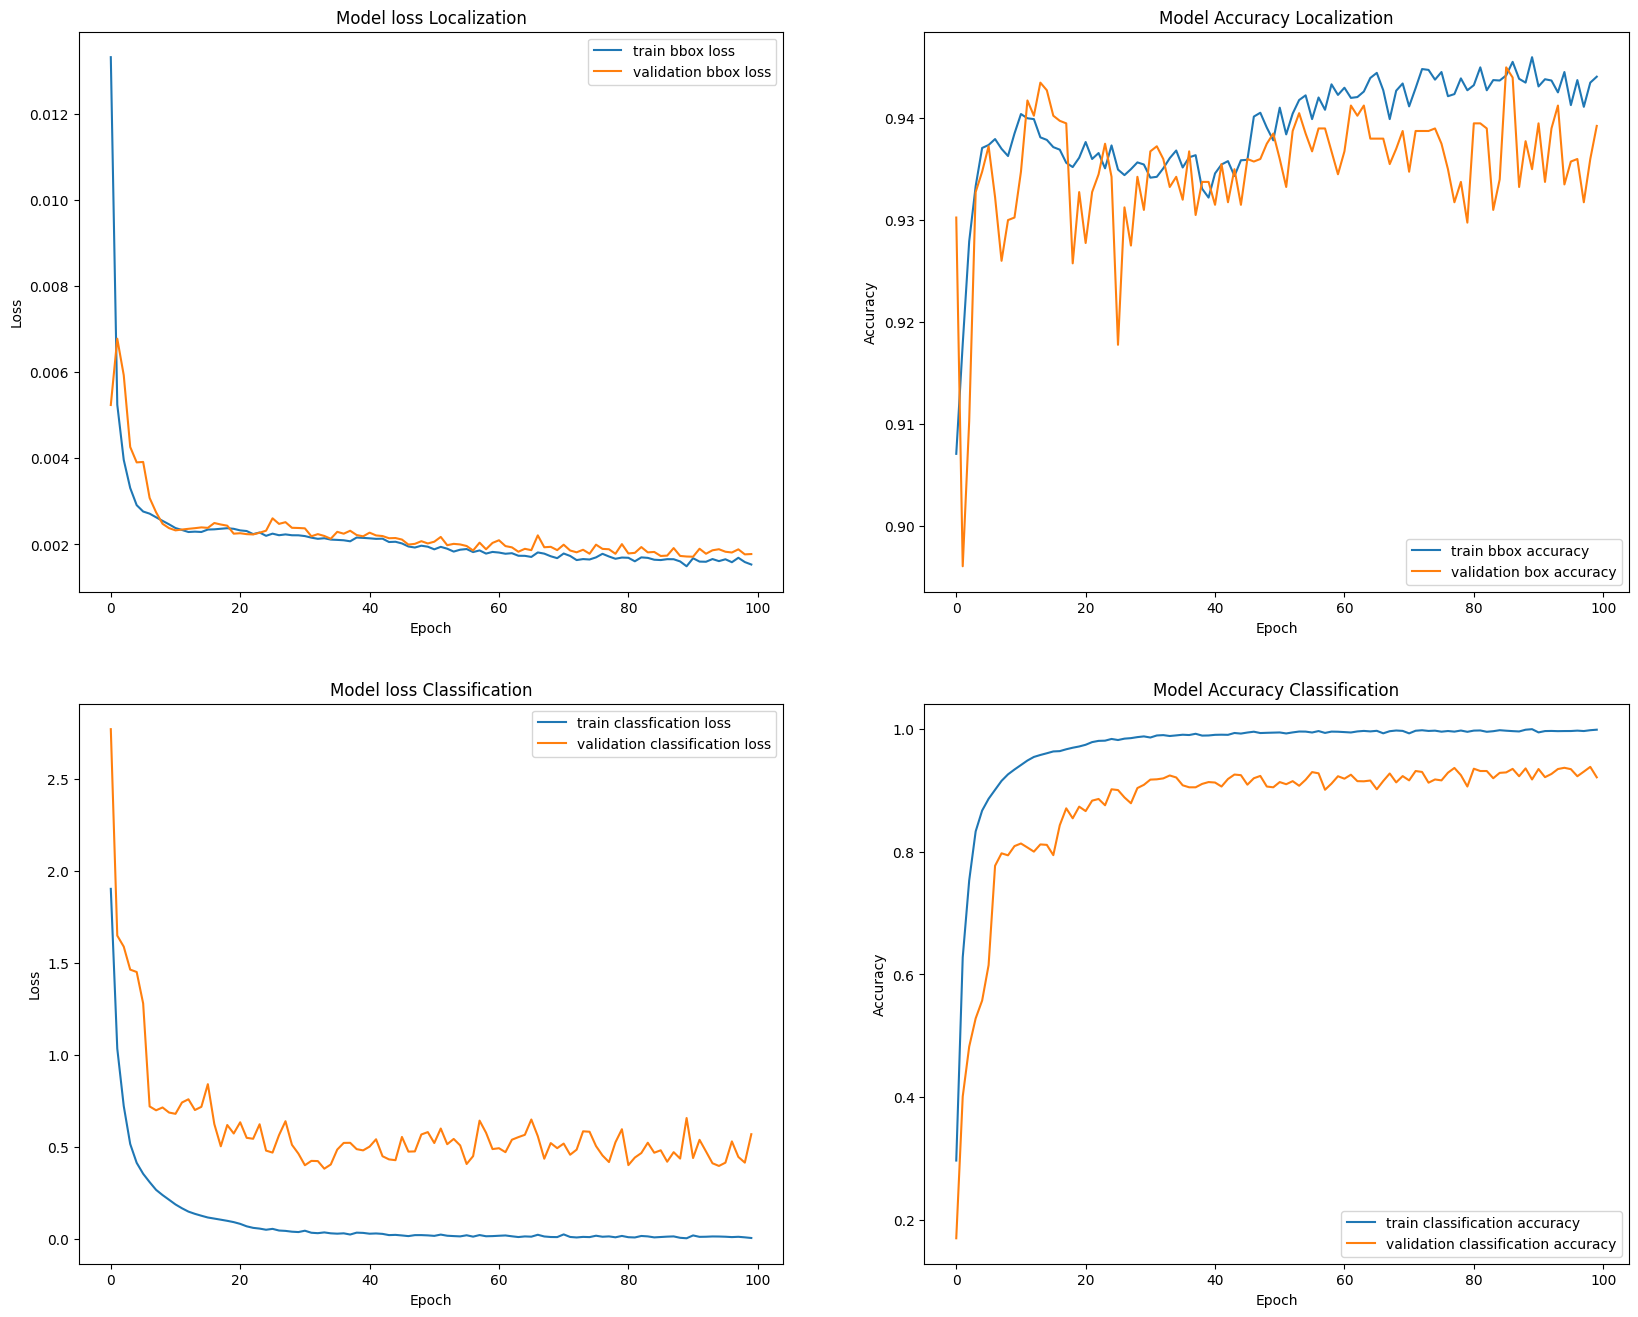

In [24]:
plot_metrics(history3)

1/1 [==============================] - 0s 62ms/step
24 38 54 68


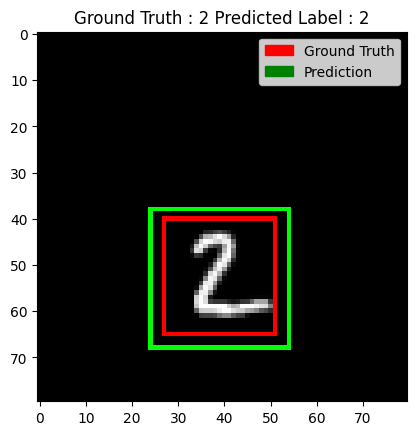

1/1 [==============================] - 0s 11ms/step
46 54 63 71


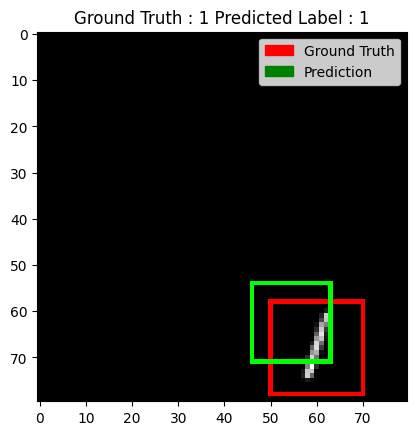

1/1 [==============================] - 0s 11ms/step
24 4 49 29


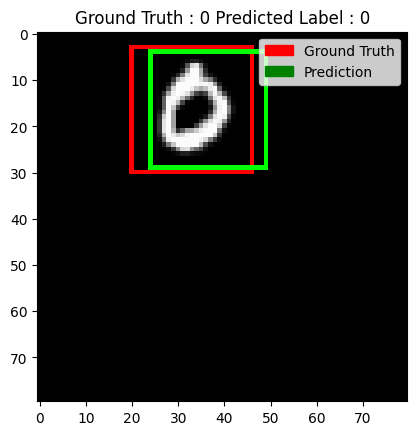

1/1 [==============================] - 0s 11ms/step
35 3 66 34


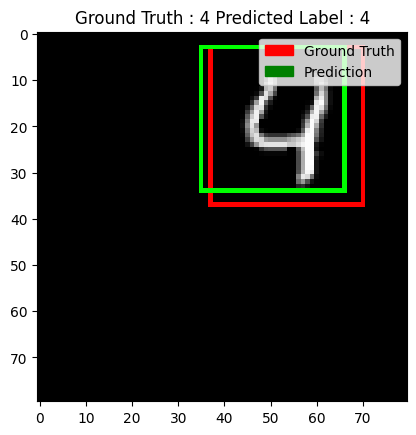

1/1 [==============================] - 0s 11ms/step
19 39 49 69


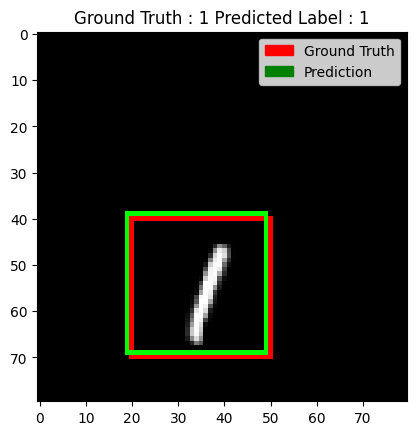

1/1 [==============================] - 0s 11ms/step
18 38 48 68


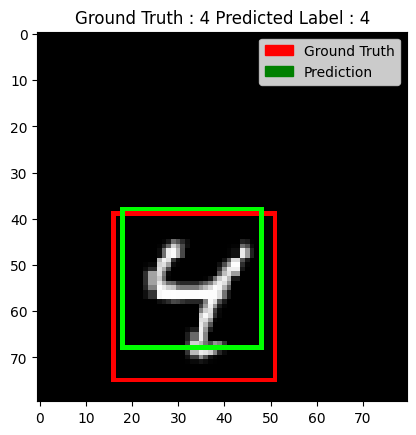

1/1 [==============================] - 0s 11ms/step
41 24 68 51


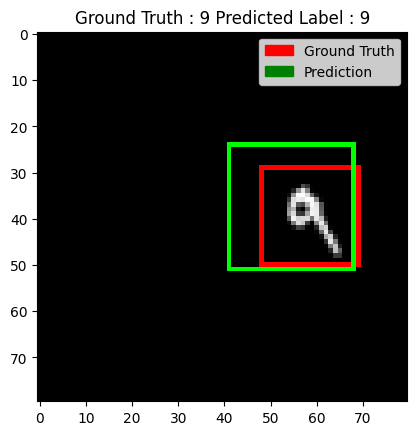

1/1 [==============================] - 0s 11ms/step
43 16 70 43


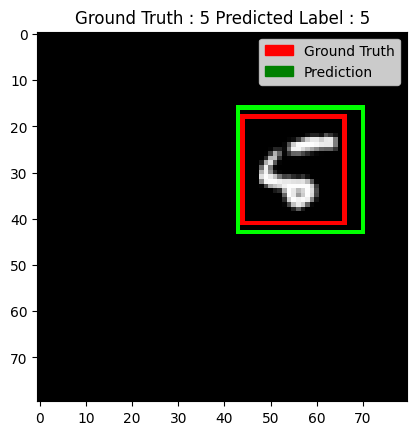

1/1 [==============================] - 0s 11ms/step
7 5 43 41


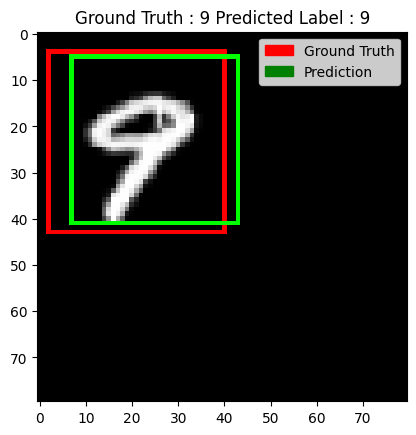

1/1 [==============================] - 0s 11ms/step
37 20 60 43


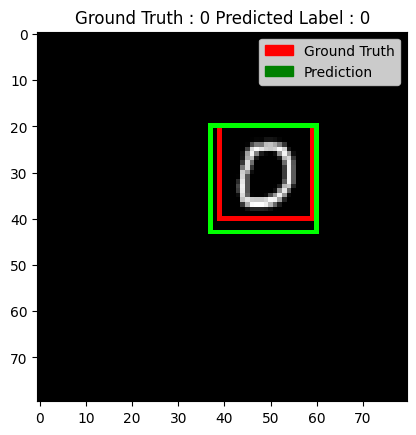

In [25]:
for i in range(10):
    predict_and_plot(1+i,conv_model3)

## Another Model

In [26]:
def convolutional_model4(input_shape):

    input_img = tf.keras.Input(shape=input_shape)
    C1 = tf.keras.layers.Conv2D(16,3,padding='same',activation='relu')(input_img)
    D1 = tf.keras.layers.Dropout(0.2)(C1)
    P1 = tf.keras.layers.MaxPool2D(pool_size=(6,6),strides=6,padding='same')(D1)
    
    C2 = tf.keras.layers.Conv2D(32,3,padding='same',activation='relu')(P1)
    D2 = tf.keras.layers.Dropout(0.2)(C2)
    P2 = tf.keras.layers.MaxPool2D(pool_size=(4,4),strides=4,padding='same')(D2)

    C3 = tf.keras.layers.Conv2D(64,3,padding='same',activation='relu')(P2)
    D3 = tf.keras.layers.Dropout(0.2)(C3)
    P3 = tf.keras.layers.MaxPool2D(pool_size=(2,2),strides=2,padding='same')(D3)

    C4 = tf.keras.layers.Conv2D(128,3,padding='same',activation='relu')(P3)
    D4 = tf.keras.layers.Dropout(0.2)(C4)
    P4 = tf.keras.layers.MaxPool2D(pool_size=(2,2),strides=2,padding='same')(D4)
    
    F = tf.keras.layers.Flatten()(P4)

    l_b1 = tf.keras.layers.Dense(32,activation='relu')(F)
    l_b1_d = tf.keras.layers.Dropout(0.2)(l_b1)
    
    c_b1 = tf.keras.layers.Dense(32,activation='relu')(F)
    c_b1_d = tf.keras.layers.Dropout(0.2)(c_b1)

    l_b2 = tf.keras.layers.Dense(16,activation='relu')(l_b1_d)
    c_b2 = tf.keras.layers.Dense(16,activation='relu')(c_b1_d)
    
    output_1 = tf.keras.layers.Dense(4,activation='linear',name='bbox_output')(l_b2)
    output_2 = tf.keras.layers.Dense(10,activation='softmax',name='class_output')(c_b2)
    
    model = tf.keras.Model(inputs=input_img, outputs=[output_1,output_2])
    return model

In [27]:
conv_model4 = convolutional_model4((80, 80,1))
conv_model4.compile(optimizer='adam',
                  loss={'bbox_output':'mean_squared_error','class_output':'categorical_crossentropy'},
                  metrics=['accuracy'])
conv_model4.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_4 (InputLayer)        [(None, 80, 80, 1)]          0         []                            
                                                                                                  
 conv2d_10 (Conv2D)          (None, 80, 80, 16)           160       ['input_4[0][0]']             
                                                                                                  
 dropout (Dropout)           (None, 80, 80, 16)           0         ['conv2d_10[0][0]']           
                                                                                                  
 max_pooling2d_10 (MaxPooli  (None, 14, 14, 16)           0         ['dropout[0][0]']             
 ng2D)                                                                                      

In [28]:
history4 = conv_model4.fit(train_dataset, epochs=100, validation_data=test_dataset)

Epoch 1/100
375/375 [==============================] - 26s 65ms/step - loss: 1.7330 - bbox_output_loss: 0.0229 - class_output_loss: 1.7101 - bbox_output_accuracy: 0.7947 - class_output_accuracy: 0.3434 - val_loss: 1.8833 - val_bbox_output_loss: 0.0500 - val_class_output_loss: 1.8332 - val_bbox_output_accuracy: 0.9025 - val_class_output_accuracy: 0.2677
Epoch 2/100
375/375 [==============================] - 24s 65ms/step - loss: 1.1554 - bbox_output_loss: 0.0112 - class_output_loss: 1.1442 - bbox_output_accuracy: 0.8590 - class_output_accuracy: 0.5641 - val_loss: 1.3470 - val_bbox_output_loss: 0.0239 - val_class_output_loss: 1.3231 - val_bbox_output_accuracy: 0.9298 - val_class_output_accuracy: 0.4830
Epoch 3/100
375/375 [==============================] - 24s 65ms/step - loss: 0.9103 - bbox_output_loss: 0.0088 - class_output_loss: 0.9014 - bbox_output_accuracy: 0.8751 - class_output_accuracy: 0.6745 - val_loss: 1.2373 - val_bbox_output_loss: 0.0143 - val_class_output_loss: 1.2230 - val_

/tmp/ipykernel_77852/3760673571.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_loss.rename(columns={'bbox_output_loss':'train bbox loss','val_bbox_output_loss':'validation bbox loss'},inplace=True)
/tmp/ipykernel_77852/3760673571.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_acc.rename(columns={'bbox_output_accuracy':'train bbox accuracy','val_bbox_output_accuracy':'validation box accuracy'},inplace=True)
/tmp/ipykernel_77852/3760673571.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/panda

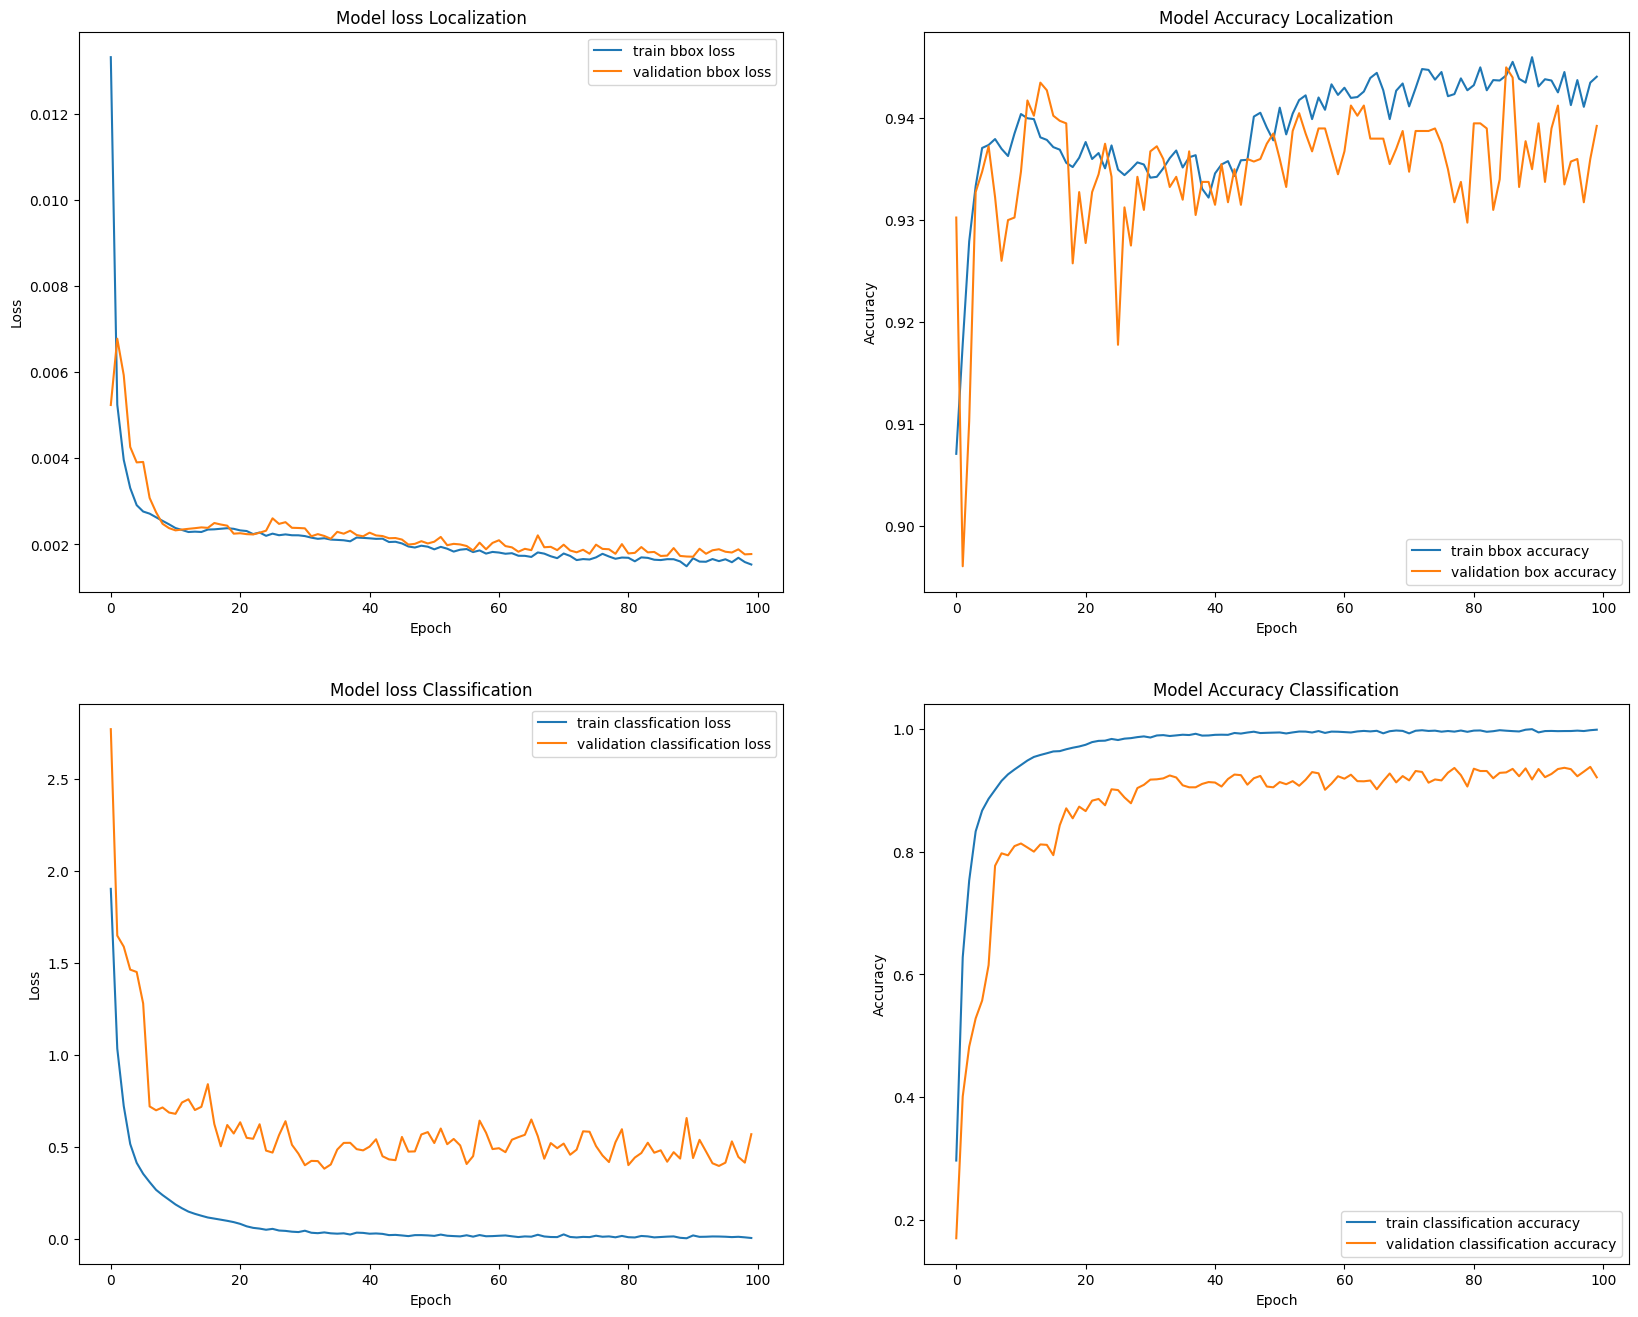

In [29]:
plot_metrics(history3)

1/1 [==============================] - 0s 12ms/step
24 38 54 68


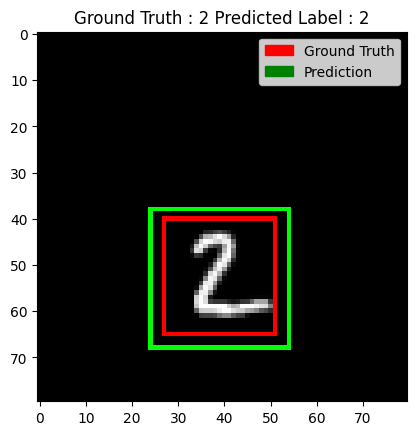

1/1 [==============================] - 0s 12ms/step
46 54 63 71


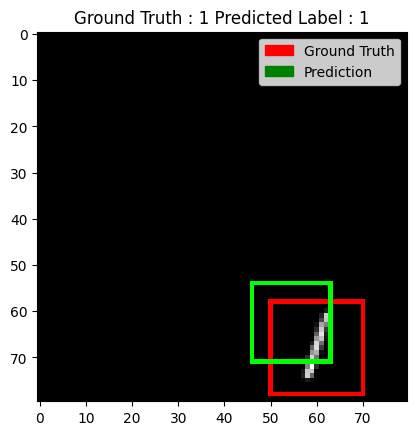

1/1 [==============================] - 0s 14ms/step
24 4 49 29


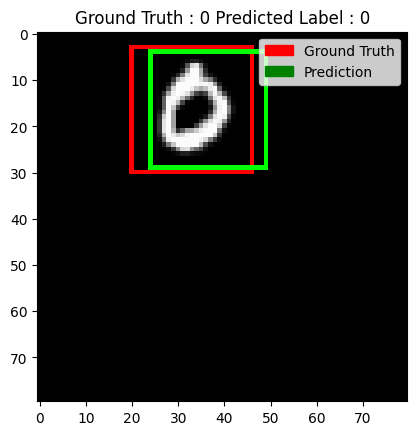

1/1 [==============================] - 0s 12ms/step
35 3 66 34


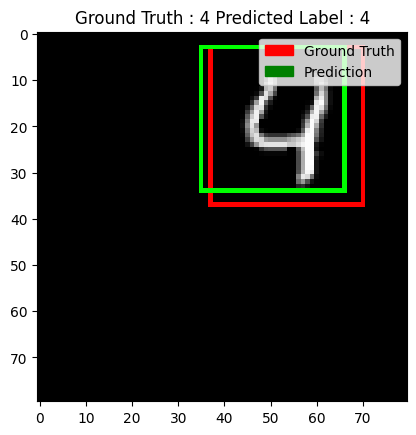

1/1 [==============================] - 0s 12ms/step
19 39 49 69


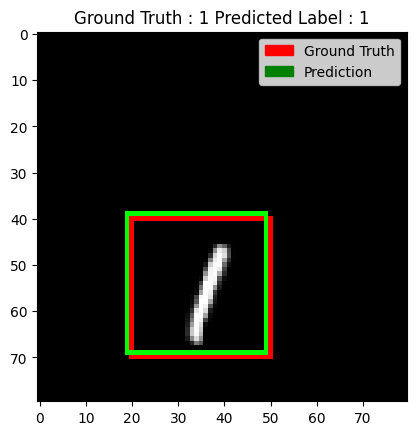

1/1 [==============================] - 0s 12ms/step
18 38 48 68


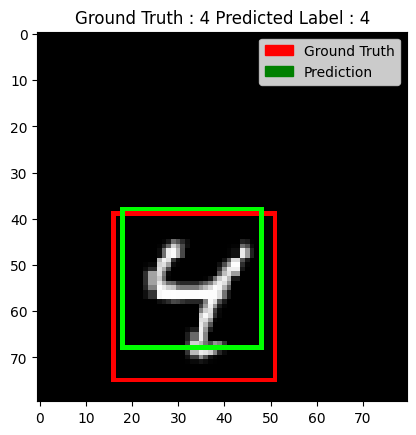

1/1 [==============================] - 0s 12ms/step
41 24 68 51


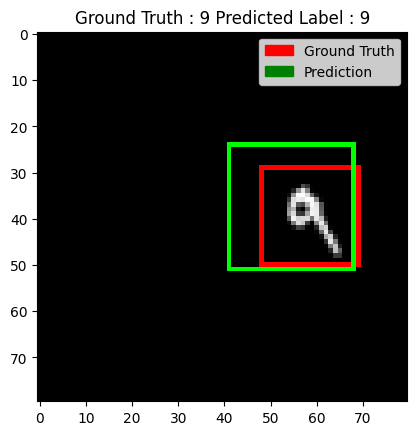

1/1 [==============================] - 0s 12ms/step
43 16 70 43


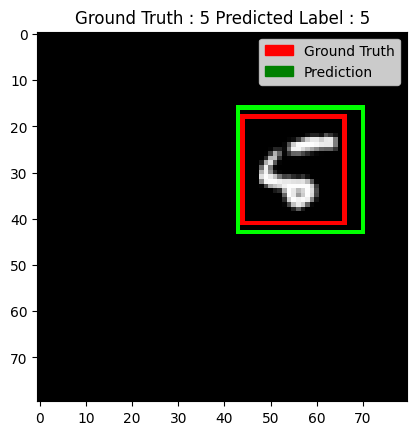

1/1 [==============================] - 0s 12ms/step
7 5 43 41


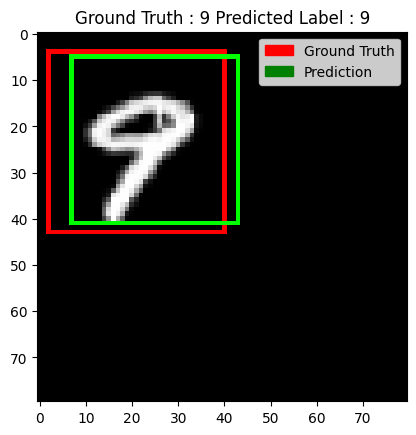

1/1 [==============================] - 0s 12ms/step
37 20 60 43


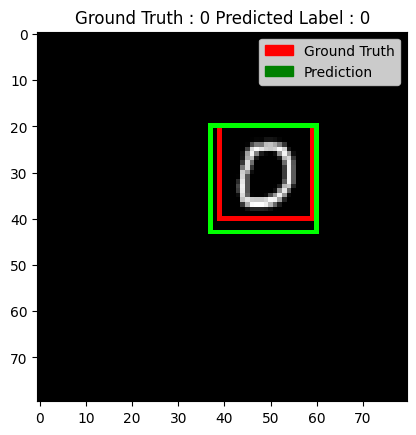

In [30]:
for i in range(10):
    predict_and_plot(1+i,conv_model3)